## Do the Estimation with SCE and SPF data


### 1. Importing estimation codes

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.optimize import minimize

import statsmodels.api as sm
from statsmodels.tsa.api import AR

In [6]:
from GMMEst import RationalExpectation as re
from GMMEst import StickyExpectation as se
from GMMEst import NoisyInformation as ni
from GMMEst import ParameterLearning as pl
from GMMEst import AR1_simulator, ForecastPlotDiag, ForecastPlot

In [ ]:
## some parameters 
rho = 0.95
sigma = 0.1
process_para = {'rho':rho,
                'sigma':sigma}

### 2. Preparing real-time data 

In [ ]:
## CPI Core
InfCPICMRT=pd.read_stata('../OtherData/InfCPICMRealTime.dta')  
InfCPICMRT = InfCPICMRT[-InfCPICMRT.date.isnull()]

## CPI 
InfCPIMRT=pd.read_stata('../OtherData/InfCPIMRealTime.dta')  
InfCPIMRT = InfCPIMRT[-InfCPIMRT.date.isnull()]

In [ ]:
## dealing with dates 
dateM_cpic = pd.to_datetime(InfCPICMRT['date'],format='%Y%m%d')
dateM_cpi = pd.to_datetime(InfCPIMRT['date'],format='%Y%m%d')

InfCPICMRT.index = pd.DatetimeIndex(dateM_cpic,freq='infer')
InfCPIMRT.index = pd.DatetimeIndex(dateM_cpi,freq='infer')

In [ ]:
## a function that turns vintage matrix to a one-dimension vector of real time data
def GetRealTimeData(matrix):
    periods = len(matrix)
    real_time = np.zeros(periods)
    for i in range(periods):
        real_time[i] = matrix.iloc[i,i+1]
    return real_time

In [ ]:
## generate real-time series 
matrix_cpic = InfCPICMRT.copy().drop(columns=['date','year','month'])
matrix_cpi = InfCPIMRT.copy().drop(columns=['date','year','month'])

real_time_cpic = pd.Series(GetRealTimeData(matrix_cpic) )
real_time_cpi =  pd.Series(GetRealTimeData(matrix_cpi) ) 
real_time_cpic.index =  InfCPICMRT.index #+ pd.DateOffset(months=1) 
real_time_cpi.index = InfCPIMRT.index #+ pd.DateOffset(months=1)

In [ ]:
## turn index into yearly inflation
real_time_index =pd.concat([real_time_cpic,real_time_cpi], join='inner', axis=1)
real_time_index.columns=['RTCPI','RTCPICore']
real_time_inf = real_time_index.pct_change(periods=12)*100

In [ ]:
real_time_inf.tail()

### 3. Estimating using real-time inflation and expectation data


In [ ]:
## exapectation data from SPF 
PopQ=pd.read_stata('../SurveyData/InfExpQ.dta')  
PopQ = PopQ[-PopQ.date.isnull()]

dateQ = pd.to_datetime(PopQ['date'],format='%Y%m%d')

dateQ_str = dateQ.dt.year.astype(int).astype(str) + \
             "Q" + dateQ.dt.quarter.astype(int).astype(str)
PopQ.index = pd.DatetimeIndex(dateQ_str)

SPFCPI = PopQ[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']].dropna(how='any')


In [ ]:
## Inflation data quarterly 
InfQ = pd.read_stata('../OtherData/InfShocksQClean.dta')
InfQ = InfQ[-InfQ.date.isnull()]
dateQ2 = pd.to_datetime(InfQ['date'],format='%Y%m%d')
dateQ_str2 = dateQ2 .dt.year.astype(int).astype(str) + \
             "Q" + dateQ2 .dt.quarter.astype(int).astype(str)
InfQ.index = pd.DatetimeIndex(dateQ_str2,freq='infer')

In [ ]:
## process parameters estimation 
# period filter 
start_t='1995-01-01'
end_t = '2019-03-30'   # the same period as in Gali (1991)

### quarterly data 
CPICQ = InfQ['Inf1y_CPICore'].copy().loc[start_t:end_t]
Y = np.array(CPICQ[1:])
X = np.array(CPICQ[:-1])

ARmodel = AR(CPICQ)
ar_rs = ARmodel.fit(1,trend='nc')
rhoQ_est = ar_rs.params[0]
sigmaQ_est = np.sqrt(sum(ar_rs.resid**2)/(len(CPICQ)-1))

In [ ]:
## Inflation data monthly
InfM = pd.read_stata('../OtherData/InfShocksMClean.dta')
InfM = InfM[-InfM.date.isnull()]
dateM = pd.to_datetime(InfM['date'],format='%Y%m%d')
#dateM_str = dateM .dt.year.astype(int).astype(str) + \
#             "M" + dateM .dt.month.astype(int).astype(str)
InfM.index = pd.DatetimeIndex(dateM,freq='infer')

In [ ]:
### monthly data 
CPIM = InfM['Inf1y_CPIAU'].copy().loc[start_t:end_t]
Y = np.array(CPIM[1:])
X = np.array(CPIM[:-1])

ARmodel2 = AR(CPIM)
ar_rs2 = ARmodel2.fit(1,trend='nc')
rhoM_est = ar_rs2.params[0]
sigmaM_est = np.sqrt(sum(ar_rs2.resid**2)/(len(CPIM)-1))

In [ ]:
## expectation data from SCE

PopM = pd.read_stata('../SurveyData/InfExpM.dta')

PopM = PopM[-PopM.date.isnull()]

dateM = pd.to_datetime(PopM['date'],format='%Y%m%d')

dateM_str = dateM.dt.year.astype(int).astype(str) + \
             "M" + dateM.dt.month.astype(int).astype(str)
PopM.index = pd.DatetimeIndex(dateM)

SCECPI = PopM[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var']].dropna(how='any')

In [ ]:
## Combine expectation data and real-time data 

SPF_est = pd.concat([SPFCPI,real_time_inf,InfQ['Inf1y_CPICore'],InfQ['Inf1yf_CPICore']], join='inner', axis=1)
SCE_est = pd.concat([SCECPI,real_time_inf,InfM['Inf1yf_CPIAU']], join='inner', axis=1)

In [ ]:
## hisotries data, the series ends at the same dates with real-time data but startes earlier 

st_t_history = '2000-01-01'
ed_t_SPF = SPF_est.index[-1].strftime('%Y%m%d')
ed_t_SCE = SCE_est.index[-1].strftime('%Y-%m-%d')

historyQ = real_time_inf.copy().loc[st_t_history:ed_t_SPF]
historyM = real_time_inf.loc[st_t_history:ed_t_SCE]

In [ ]:
# How large is the difference between current vintage and real-time data
rev = SPF_est['Inf1y_CPICore'] - SPF_est['RTCPICore']

plt.style.use('ggplot')
plt.figure(figsize=([6,4]))
hist_rv = plt.hist(rev,
                   bins=30,
                   density = True)
plt.title('Core CPI Revisions between Real-time \n \
    data and the Current Vintage')
plt.ylabel('Density(0-1)',size=12)
plt.xlabel('Current Vintage - Real-Time',size=12)
plt.savefig('figures/hist_rev_realtime.png')

In [ ]:
# real time inflation 
real_time = np.array(SPF_est['RTCPI'])

ax = SPF_est[['RTCPI','Inf1y_CPICore']].plot(style=['s-','o-'],
                                             figsize=([6,4]))
#plt.style.use('ggplot')
ax.set_title('Real-time and Current-vintage Core CPI ')
ax.set_xlabel('Date')
ax.set_ylabel('Core CPI (%)')
ax.legend(['Real-time', 'Current-vintage'])
plt.savefig('figures/ts_rev_realtime.png')

In [ ]:
## realized 1-year-ahead inflation
realized_CPIC = np.array(SPF_est['Inf1yf_CPICore'])
realized_CPI = np.array(SCE_est['Inf1yf_CPIAU'])
#SPF_est['Inf1yf_CPICore'].plot()
#plt.title('Realized 1-year-ahead Core CPI Inflation')

In [190]:
## preparing for estimation 

exp_data_SPF = SPF_est[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']]
exp_data_SPF.columns = ['Forecast','FE','Disg','Var']
data_moms_dct_SPF = dict(exp_data_SPF)

exp_data_SCE = SCE_est[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var']]
exp_data_SCE.columns = ['Forecast','FE','Disg','Var']
data_moms_dct_SCE = dict(exp_data_SCE)

In [191]:
## SE estimation for SPF
real_time = np.array(SPF_est['RTCPI'])
history_Q = historyQ['RTCPICore']

data_moms_dct = data_moms_dct_SPF


process_paraQ_est = {'rho':rhoQ_est,
                    'sigma':sigmaQ_est}

SE_model = se(real_time = real_time,
              history = history_Q,
              process_para = process_paraQ_est)
SE_model.moments = ['Forecast','FE','Disg']
SE_model.GetRealization(realized_CPIC)
SE_model.GetDataMoments(data_moms_dct)
SE_model.ParaEstimate(options={'disp':True})

Optimization terminated successfully.
         Current function value: 8.524652
         Iterations: 5
         Function evaluations: 21
         Gradient evaluations: 7


array([0.22667516])

In [192]:
lbd_est_SPF = SE_model.para_est
lbd_est_SPF

array([0.22667516])

In [195]:
SE_model.all_moments = ['Forecast','FE','Disg']
SE_model.ForecastPlotDiag(all_moms = True)

TypeError: ForecastPlotDiag() got an unexpected keyword argument 'all_moms'

In [139]:
## Joint estimation for SPF

real_time = np.array(SPF_est['RTCPI'])
history_Q = historyQ['RTCPICore']

data_moms_dct = data_moms_dct_SPF


process_paraQ_est = {'rho':rhoQ_est,
                    'sigma':sigmaQ_est}

SE_model = se(real_time = real_time,
              history = history_Q,
              process_para = process_paraQ_est)
SE_model.moments = ['Forecast','FE','Disg']
SE_model.GetRealization(realized_CPIC)
SE_model.GetDataMoments(data_moms_dct)
SE_model.ParaEstimateJoint(method='L-BFGS-B',
                           para_guess =(0.5,0.8,0.1),
                           bounds = ((0,1),(0,1),(0,None)),
                           options={'disp':True})

In [140]:
SE_model.para_est_joint

array([0.05304974, 1.        , 0.1       ])

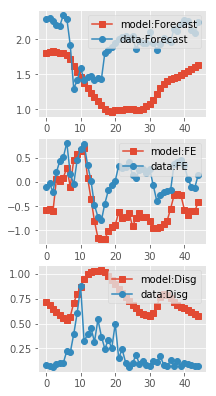

In [141]:
se_spf_joint_plot = SE_model.ForecastPlotDiagJoint()

moments used include ['Forecast']
Optimization terminated successfully.
         Current function value: 5.953709
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
         Current function value: 4.282472
         Iterations: 26
         Function evaluations: 597
         Gradient evaluations: 117
moments used include ['FE']
Optimization terminated successfully.
         Current function value: 5.996947
         Iterations: 3
         Function evaluations: 21
         Gradient evaluations: 7
         Current function value: 4.287149
         Iterations: 23
         Function evaluations: 667
         Gradient evaluations: 131
moments used include ['Forecast', 'FE']
Optimization terminated successfully.
         Current function value: 8.450937
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
         Current function value: 4.658738
         Iterations: 30
         Function evaluations: 706
         Gradie

/Users/Myworld/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/Myworld/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


         Current function value: 8.333289
         Iterations: 13
         Function evaluations: 325
         Gradient evaluations: 60
[array([0.20853837]), array([0.18469843]), array([0.19765964]), array([0.22667517])]
[array([0.00463227, 1.00425166, 0.1       ]), array([0.0043265 , 1.00455299, 0.1       ]), array([0.00437605, 1.00450765, 0.1       ]), array([0.13863688, 1.0172818 , 0.1       ])]


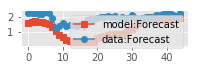

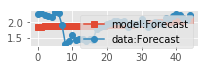

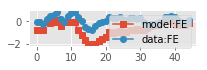

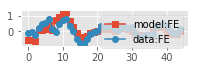

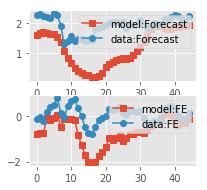

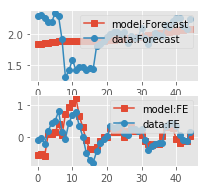

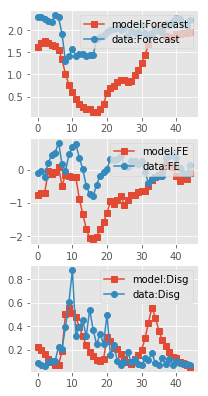

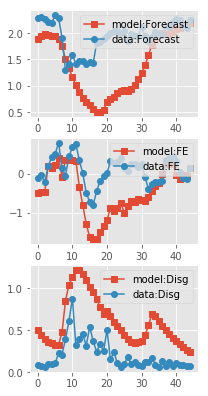

In [142]:
## loop estimation overdifferent choieces of moments for SPF

moments_choices = [['Forecast'],
                   ['FE'],
                   ['Forecast','FE'],
                   ['Forecast','FE','Disg']]

para_est_SPF_holder = []
para_est_SPF_joint_holder = []

### loop starts from here for SPF 

for i,moments_to_use in enumerate(moments_choices):
    print("moments used include "+ str(moments_to_use))
    real_time = np.array(SPF_est['RTCPI'])
    history_Q = historyQ['RTCPICore']
    data_moms_dct = data_moms_dct_SPF
    process_paraQ_est = {'rho':rhoQ_est,
                         'sigma':sigmaQ_est}
    SE_model = se(real_time = real_time,
                  history = history_Q,
                  process_para = process_paraQ_est)
    SE_model.moments = moments_to_use
    SE_model.GetRealization(realized_CPIC)
    SE_model.GetDataMoments(data_moms_dct)
    
    # only expectation
    SE_model.ParaEstimate(method='CG',
                          options={'disp':True})
    para_est_SPF_holder.append(SE_model.para_est)
    SE_model.ForecastPlotDiag()
    plt.savefig('figures/spf_se_est_diag'+str(i)+'.png')
    
    # joint estimate
    SE_model.ParaEstimateJoint(method='CG',
                               para_guess =(0.5,0.8,0.1),
                               options={'disp':True})
    para_est_SPF_joint_holder.append(SE_model.para_est_joint)
    SE_model.ForecastPlotDiagJoint()
    plt.savefig('figures/spf_se_est_joint_diag'+str(i)+'.png')
    
print(para_est_SPF_holder)
print(para_est_SPF_joint_holder)

In [144]:
## tabulate the estimates 
spf_se_est_para = pd.DataFrame(para_est_SPF_holder,columns=[r'SE: $\hat\lambda_{SPF}$(Q)'])
spf_se_joint_est_para = pd.DataFrame(para_est_SPF_joint_holder,
                                     columns=[r'SE: $\hat\lambda_{SPF}$(Q)',
                                              r'SE: $\rho$',
                                              r'SE: $\sigma$'])

In [145]:
spf_se_joint_est_para

,SE: $\hat\lambda_{SPF}$(Q),$\rho$,$\sigma$
0,0.004632,1.004252,0.1
1,0.004327,1.004553,0.1
2,0.004376,1.004508,0.1
3,0.138637,1.017282,0.1


In [33]:
## loop estimation overdifferent choieces of moments for SCE

moments_choices = [['Forecast'],
                   ['FE'],
                   ['Forecast','FE'],
                   ['Forecast','FE','Disg']]

para_est_SCE_holder = []
para_est_SCE_joint_holder


for moments_to_use in moments_choices:
    print("moments used include "+ str(moments_to_use))
    real_time = np.array(SCE_est['RTCPI'])
    history_M = historyM['RTCPI']
    data_moms_dct = data_moms_dct_SCE
    process_paraM_est = {'rho':rhoM_est,
                         'sigma':sigmaM_est}
    SE_model2 = se(real_time = realized_CPI,
                   history = history_M,
                   process_para = process_paraM_est)
    SE_model2.moments = moments_to_use
    SE_model2.GetRealization(realized_CPI)
    SE_model2.GetDataMoments(data_moms_dct)
    
    ## only expectation
    SE_model2.ParaEstimate(method='CG',
                           options={'disp':True})
    para_est_SCE_holder.append(SE_model2.para_est)
    SE_model2.ForecastPlotDiag()
    plt.savefig('figures/sce_se_est_diag'+str(i)+'.png')
    
    ## joint estimation
    
    SE_model2.ParaEstimateJoint(method='CG',
                                options={'disp':True})
    para_est_SCE_joint_holder.append(SE_model2.para_est_joint)
    SE_model2.ForecastPlotDiag()
    plt.savefig('figures/sce_se_est_joint_diag'+str(i)+'.png')

print(para_est_SCE_holder)
print(para_est_SCE_joint_holder)

moments used include ['Forecast']
Optimization terminated successfully.
         Current function value: 12.819670
         Iterations: 3
         Function evaluations: 33
         Gradient evaluations: 11
moments used include ['FE']
Optimization terminated successfully.
         Current function value: 9.459044
         Iterations: 8
         Function evaluations: 36
         Gradient evaluations: 12
moments used include ['Forecast', 'FE']
Optimization terminated successfully.
         Current function value: 15.932258
         Iterations: 5
         Function evaluations: 30
         Gradient evaluations: 10
moments used include ['Forecast', 'FE', 'Disg']
Optimization terminated successfully.
         Current function value: 167.452258
         Iterations: 4
         Function evaluations: 54
         Gradient evaluations: 18
[array([1.79919019]), array([1.73748106]), array([1.77484545]), array([0.02434184])]


In [51]:
sce_se_est_para = pd.DataFrame(para_est_SCE_holder,
                               columns=[r'SE: $\hat\lambda_{SCE}$(M)'])
sce_se_joint_est_para = pd.DataFrame(para_est_SCE_joint_holder,
                                     columns=[r'SE: $\hat\lambda_{SCE}$(Q)',
                                              r'SE: $\rho$',
                                              r'SE: $\sigma$'])


#sce_se_est_df = pd.concat([sce_se_est_moms,sce_se_joint_est_para], join='inner', axis=1)

In [ ]:
est_moms = pd.DataFrame(moments_choices)

## combining SCE and SPF 
se_est_df = pd.concat([est_moms,
                       spf_se_est_para,
                       spf_se_joint_est_para,
                       sce_se_est_para,
                       sce_se_joint_est_para,], 
                      join='inner', axis=1)

In [52]:
se_est_df

,0,1,2,SE: $\hat\lambda_{SPF}$(Q),SE: $\hat\lambda_{SCE}$(M)
0,Forecast,None,None,0.208538,1.799190
1,FE,None,None,0.184698,1.737481
2,Forecast,FE,None,0.197660,1.774845
3,Forecast,FE,Disg,0.226675,0.024342


In [47]:
## SE estimation for SCE
real_time = np.array(SCE_est['RTCPI'])
history_M = historyM['RTCPI']
data_moms_dct = data_moms_dct_SCE


process_paraM_est = {'rho':rhoM_est,
                    'sigma':sigmaM_est}

SE_model2 = se(real_time = realized_CPI,
               history = history_M,
               process_para = process_paraM_est)
SE_model2.moments = ['Forecast']
SE_model2.GetRealization(realized_CPI)
SE_model2.GetDataMoments(data_moms_dct)
SE_model2.ParaEstimate(method ='L-BFGS-B',
                       options = {'disp':True})


lbd_est_SCE = SE_model2.para_est

In [48]:
lbd_est_SCE

array([1.79918888])

In [ ]:
## what is the estimated lambda?
print("SPF: "+str(lbd_est_SPF))
print("SCE: "+str(lbd_est_SCE))

## rough estimation that did not take care of following issues
## quarterly survey of 1-year-ahead forecast
## real-time data is yearly 

In [ ]:
## compare the data with estimation for SPF
SE_model.ForecastPlotDiag()

In [ ]:
## compare the data with estimation for SCE
SE_model2.ForecastPlotDiag()

In [ ]:
## NI estimation for SPF

real_time = np.array(SPF_est['RTCPI'])
data_moms_dct = data_moms_dct_SPF

process_paraQ_est = {'rho':rhoQ_est,
                    'sigma':sigmaQ_est}

NI_model = ni(real_time = real_time,
              history = history_Q,
              process_para = process_paraQ_est,
              moments = ['Forecast','FE','Disg','Var'])
NI_model.SimulateSignals()
NI_model.GetRealization(realized_CPIC)
NI_model.GetDataMoments(data_moms_dct)
NI_model.ParaEstimate(method = 'L-BFGS-B',
                      bounds = ((0,None),(0,None),(0,None)),
                      para_guess = np.array([0.01,0.01,0.01]),
                      options={'disp':True})

sigmas_est_SPF = NI_model.para_est

In [ ]:
sigmas_est_SPF

In [ ]:
plt.plot(NI_model.signals_pb,'--',label='public signals')
plt.plot(NI_model.history,'r*',label='history')
plt.legend()

In [ ]:
## compare the data with estimation for SPF
NI_model.ForecastPlotDiag()

In [ ]:
## NI estimation for SCE

real_time = np.array(SCE_est['RTCPI'])
data_moms_dct = data_moms_dct_SCE

process_paraM_est = {'rho':rhoM_est,
                    'sigma':sigmaM_est}

NI_model2 = ni(real_time = real_time,
               history = history_M,
               process_para = process_paraM_est)
NI_model2.SimulateSignals()
NI_model2.GetRealization(realized_CPI)
NI_model2.GetDataMoments(data_moms_dct)
NI_model2.moments = ['Forecast','FE','Disg','Var']
NI_model2.ParaEstimate(method = 'L-BFGS-B',
                       bounds = ((0,None),(0,None),(0,None)),
                       options={'disp':True})

sigmas_est_SCE = NI_model2.para_est

In [64]:
sigmas_est_SCE

array([ 5329.26176221,   332.66740906, 14215.10002247])

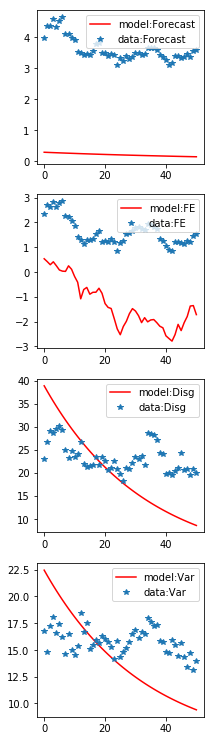

In [65]:
## compare the data with estimation for SCE

NI_model2.ForecastPlotDiag()

In [66]:
print(str(sigmas_est_SPF))
print(str(sigmas_est_SCE))

[0.80760731 2.16168125 0.01000169]
[ 5329.26176221   332.66740906 14215.10002247]


In [36]:
### Estimate of Parameter Learning for SPF

real_time = np.array(SPF_est['RTCPI'])
data_moms_dct = data_moms_dct_SPF

process_paraQ_est = {'rho':rhoQ_est,
                    'sigma':sigmaQ_est}

PL_model = pl(real_time = real_time,
              history = history_Q,
              process_para = process_paraQ_est,
              moments = ['Forecast','FE','Disg','Var'])

PL_model.GetRealization(realized_CPIC)
PL_model.LearnParameters()
moms_pl_sim = PL_model.Forecaster()
PL_model.GetDataMoments(data_moms_dct)

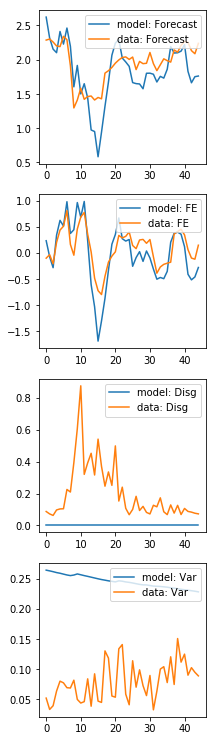

In [37]:
pl_plot = ForecastPlotDiag(moms_pl_sim,
                           data_moms_dct,
                           legends=['model','data'])

In [38]:
### Estimate of Parameter Learning for SCE

real_time = np.array(SCE_est['RTCPI'])
data_moms_dct2 = data_moms_dct_SCE

process_paraM_est = {'rho':rhoM_est,
                    'sigma':sigmaM_est}

PL_model2 = pl(real_time = real_time,
              history = history_M,
              process_para = process_paraM_est,
              moments = ['Forecast','FE','Disg','Var'])

PL_model2.GetRealization(realized_CPI)
PL_model2.LearnParameters()
moms_pl_sim2 = PL_model2.Forecaster()
PL_model2.GetDataMoments(data_moms_dct2)

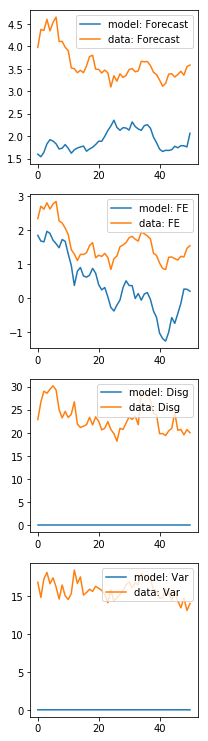

In [39]:
pl_plot = ForecastPlotDiag(moms_pl_sim2,
                           data_moms_dct2,
                           legends=['model','data'])

In [2]:
'''
NI_model_sim_est = {'sigma_pb':sigmas_est_SPF[0][0],
                'sigma_pr':sigmas_est_SPF[0][1],
                'var_init':sigmas_est_SPF[0][2]}

NI_model.exp_para = NI_model_sim_est
NI_model.SimulateSignals()
ni_sim_moms_dct = NI_model.Forecaster()
'''

"\nNI_model_sim_est = {'sigma_pb':sigmas_est_SPF[0][0],\n                'sigma_pr':sigmas_est_SPF[0][1],\n                'var_init':sigmas_est_SPF[0][2]}\n\nNI_model.exp_para = NI_model_sim_est\nNI_model.SimulateSignals()\nni_sim_moms_dct = NI_model.Forecaster()\n"

In [3]:
#NI_model.exp_para

In [4]:
'''
plt.figure(figsize=([3,13]))
for i,key in enumerate(ni_sim_moms_dct):
    plt.subplot(4,1,i+1)
    print(key)
    plt.plot(ni_sim_moms_dct[key],label='Model')
    plt.plot(np.array(data_moms_dct_SPF[key]),label='Data')
    plt.legend(loc=1)
'''

"\nplt.figure(figsize=([3,13]))\nfor i,key in enumerate(ni_sim_moms_dct):\n    plt.subplot(4,1,i+1)\n    print(key)\n    plt.plot(ni_sim_moms_dct[key],label='Model')\n    plt.plot(np.array(data_moms_dct_SPF[key]),label='Data')\n    plt.legend(loc=1)\n"